<div style="text-align: center;">
    <h1 style="color: green;">Anexo 15</h1>
    <h3>Proyecto 15: Resumen de textos con Text Rank</h3>
    <hr/>
    <p style="text-align: right;">Mg. Luis Felipe Bustamante Narváez</p>
</div>

En este ejercicio, desarrollaremos un generador de resumen de textos avanzado, utilizando el método TextRank, el cual permite analizar la similitud de las oraciones y palabras para contextualizar las ideas principales del tecto original.

Recordemos que el TextRank está basado en el PageRank de Google, donde las oraciones o palabras equivalen a las páginas web y la similitud entre las oraciones o palabras, representan los enlaces que estas páginas tienen con otras páginas importantes.

## Librerías

In [ ]:
pip install networkx

In [68]:
import pandas as pd
import numpy as np
import textwrap
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 
import textwrap
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luis_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luis_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Cargamos los Datos

In [27]:
path = 'data/df_total.csv'
df = pd.read_csv(path, encoding='utf-8')

In [28]:
df

,url,news,Type
0,https://www.larepublica.co/redirect/post/3201905,Durante el foro La banca articulador empresari...,Otra
1,https://www.larepublica.co/redirect/post/3210288,El regulador de valores de China dijo el domin...,Regulaciones
2,https://www.larepublica.co/redirect/post/3240676,En una industria históricamente masculina como...,Alianzas
3,https://www.larepublica.co/redirect/post/3342889,Con el dato de marzo el IPC interanual encaden...,Macroeconomia
4,https://www.larepublica.co/redirect/post/3427208,Ayer en Cartagena se dio inicio a la versión n...,Otra
...,...,...,...
1212,https://www.bbva.com/es/como-lograr-que-los-in...,En la vida de toda empresa emergente llega un ...,Innovacion
1213,https://www.bbva.com/es/podcast-como-nos-afect...,La espiral alcista de los precios continúa y g...,Macroeconomia
1214,https://www.larepublica.co/redirect/post/3253735,Las grandes derrotas nacionales son experienci...,Alianzas
1215,https://www.bbva.com/es/bbva-y-barcelona-healt...,BBVA ha alcanzado un acuerdo de colaboración c...,Innovacion


In [29]:
print(df['news'][2][:500])

En una industria históricamente masculina como lo es la aviación Viva presentó su avión rosado A320NEO que apuesta por la equidad de género la lucha contra el cáncer de mama la inclusión y la diversidad.Desde Francia llegó Go Pink que tuvo un precio promedio de US50 millones convirtiéndose en la aeronave número 20 de las 21 con las que finalizará el año esta aerolínea.En Viva estamos trabajando muy fuerte para que haya más mujeres. Actualmente el grupo ejecutivo está compuesto por 42 mujeres per


In [30]:
# Buscamos una noticia larga para tomar como ejemplo a la hora de hacer el resumen
doc = df['news'].sample()

In [35]:
print(doc.iloc[0][:500])

El crecimiento global será en los próximos dos años levemente más bajo a lo esperado pero se mantendrá robusto. Tras una caída del 32 en 2020 se estima que el PIB mundial creció alrededor de 60 en 2021 y que se expandirá 44 en 2022 y 38 en 2023.El informe de BBVA Research Situación Argentina 1 trimestre 2022 sostiene que la persistencia de la pandemia y de los problemas en las cadenas de suministro globales además de frenar el crecimiento económico mantendrán la inflación global elevada principa


In [36]:
# Obtener el índice de la noticia para manipulación de datos
indice = df.index[df['news'] == doc.iloc[0]].tolist()
print(indice)

[804]


In [37]:
# hacemos la prueba con un texto que tiene bastante texto
print(df['news'][257][:100])

Como cambiarle a un coche su motor diésel por uno eléctrico mientras está en marcha. Esta analogía d


In [38]:
#Buscamos el texto largo que encontramos en una fase de pruebas
doc = df.loc[257, 'news']

In [41]:
doc[:500]

'Como cambiarle a un coche su motor diésel por uno eléctrico mientras está en marcha. Esta analogía define la tarea titánica que ha supuesto para Ethereum su última actualización. Fruto de un trabajo de varios años, ‘The Merge’ constituye un cambio de paradigma sobre cómo se generan los criptoactivos de forma más segura y sostenible (elimina hasta un 99,95% de la energía necesaria hasta ahora), y permitirá que las finanzas descentralizadas (DeFi) afronten la implantación a gran escala. Pero tambi'

## Procesamiento de Datos

### TextWrap

In [42]:
# Eliminamos las palabras cortadas de las líneas
doc2 = textwrap.fill(doc, replace_whitespace=False, fix_sentence_endings=True)

In [43]:
print(doc2[:500])

Como cambiarle a un coche su motor diésel por uno eléctrico mientras
está en marcha.  Esta analogía define la tarea titánica que ha
supuesto para Ethereum su última actualización.  Fruto de un trabajo
de varios años, ‘The Merge’ constituye un cambio de paradigma sobre
cómo se generan los criptoactivos de forma más segura y sostenible
(elimina hasta un 99,95% de la energía necesaria hasta ahora), y
permitirá que las finanzas descentralizadas (DeFi) afronten la
implantación a gran escala.  Pero ta


### Separación en líneas

In [44]:
# Podemos separar por líneas, por puntos o comas, la idea es conservar oraciones
# con ideas claras.
lineas = doc2.split('. ')  #Usamos punto espacio, por las siglas o números que pueden haber

In [45]:
len(lineas)

24

In [46]:
lineas[22:]

[' Pero ahora\nGary Gensler, presidente de la SEC (la Comisión de Bolsa y Valores de\nEstados Unidos), ha apuntado a la posibilidad de categorizarlo como un\nvalor, ya que con la fórmula del PoS se comporta como tal (genera\ndividendos a través del depósito), lo que lo sometería a las\nnormativas que regulan los valores.\r\nBrett Harrison, presidente de la\nplataforma de criptoactivos FTX.US, ha recordado que esta complejidad\naumenta al existir diferentes tipos de participación',
 ' Un usuario\npuede depositar sus ‘tokens’ para convertirse en validador, participar\nde manera indirecta a través de un ‘exchange’, como se ha mencionado\nanteriormente, o prestarlos en protocolos financieros descentralizados\nen los que obtener también rendimientos.\r\nEl debate está sobre la\nmesa.']

### Eliminación de oraciones vacías

In [47]:
lineas = [item for item in lineas if item.strip()]

In [48]:
len(lineas)

24

In [49]:
lineas[22:]

[' Pero ahora\nGary Gensler, presidente de la SEC (la Comisión de Bolsa y Valores de\nEstados Unidos), ha apuntado a la posibilidad de categorizarlo como un\nvalor, ya que con la fórmula del PoS se comporta como tal (genera\ndividendos a través del depósito), lo que lo sometería a las\nnormativas que regulan los valores.\r\nBrett Harrison, presidente de la\nplataforma de criptoactivos FTX.US, ha recordado que esta complejidad\naumenta al existir diferentes tipos de participación',
 ' Un usuario\npuede depositar sus ‘tokens’ para convertirse en validador, participar\nde manera indirecta a través de un ‘exchange’, como se ha mencionado\nanteriormente, o prestarlos en protocolos financieros descentralizados\nen los que obtener también rendimientos.\r\nEl debate está sobre la\nmesa.']

## Vectorización

In [50]:
# Creamos la tokenización usando las stopwords descargadas
tokenizar = TfidfVectorizer(stop_words=stopwords.words('spanish'), norm='l1')

In [51]:
# Creamos la matriz
X = tokenizar.fit_transform(lineas)
X

<24x402 sparse matrix of type '<class 'numpy.float64'>'
	with 539 stored elements in Compressed Sparse Row format>

In [52]:
# Mostramos la matriz
filas, columnas = X.shape

for i in range(10):  #aquí ponemos las filas, pero al ser muchas el resultado es extenso.
    for j in range(10):
        print(X[i, j], end=' ') # imprime el elemento y un espacio en blanco
    print()  #deja el renglón

# Cada fila va a representar una palabra
# Cada columna va a representar cada una de las oraciones

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.022037911607183422 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0467110969446465 0.0 0.0 0.0 0.0 


## Calculamos la similitud

In [53]:
# Matriz de similitud
S = cosine_similarity(X)

In [54]:
S.shape

(24, 24)

In [55]:
# Muestra de similitudes, por ejemplo la oración 0, tiene similitud de 0.1248 con la
# oración 6.
S[:1]

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.12486586, 0.        , 0.        , 0.12170713,
        0.07641065, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

## Normalización

In [56]:
S = S / S.sum(axis=1, keepdims=True)

In [57]:
S[:1]

array([[0.75586724, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.09438202, 0.        , 0.        , 0.09199444,
        0.05775631, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

In [58]:
# Probamos
S[0].sum()

1.0

## Suavizado (Markov)

In [59]:
# Matriz de transición uniforme
U = np.ones_like(S)

In [60]:
U[:1]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]])

In [61]:
U.shape

(24, 24)

### Normalizamos la matriz de transición

In [62]:
U = U / len(U)

In [63]:
U[:1]

array([[0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667]])

### Matriz de similitud suavizada

In [64]:
factor = 0.1  #valor pequeño para omitir ceros
S_s = (1 - factor)*S + factor*U

In [65]:
S_s[:1]

array([[0.68444718, 0.00416667, 0.00416667, 0.00416667, 0.00416667,
        0.00416667, 0.08911048, 0.00416667, 0.00416667, 0.08696166,
        0.05614734, 0.00416667, 0.00416667, 0.00416667, 0.00416667,
        0.00416667, 0.00416667, 0.00416667, 0.00416667, 0.00416667,
        0.00416667, 0.00416667, 0.00416667, 0.00416667]])

#### Explicación

La matriz original contiene valores 0.0 con los cuales es imposible calcular promedios cuando toda una fila tenga estos valores, lo que generará errores de ejecución o desbordamientos en los resultados. En este caso, usaremos el suavizado de Laplace de Markov, agregando un porcentaje mínimo de selección de los datos con la matriz de transición normalizada, luego aplicamos la fórmula S_s = (1 - factor)*S + factor*U que utiliza un factor pequeño que dividirá los resultados para este caso en un 90% del total, para usar el 10% restante que modifica los ceros posibles encontrados en cada posición de la matriz.

## Grafo

Debemos crearlo por aparte

In [70]:
# Creamos el grafo
G = nx.from_numpy_array(S_s)
scores_G = nx.pagerank(G)

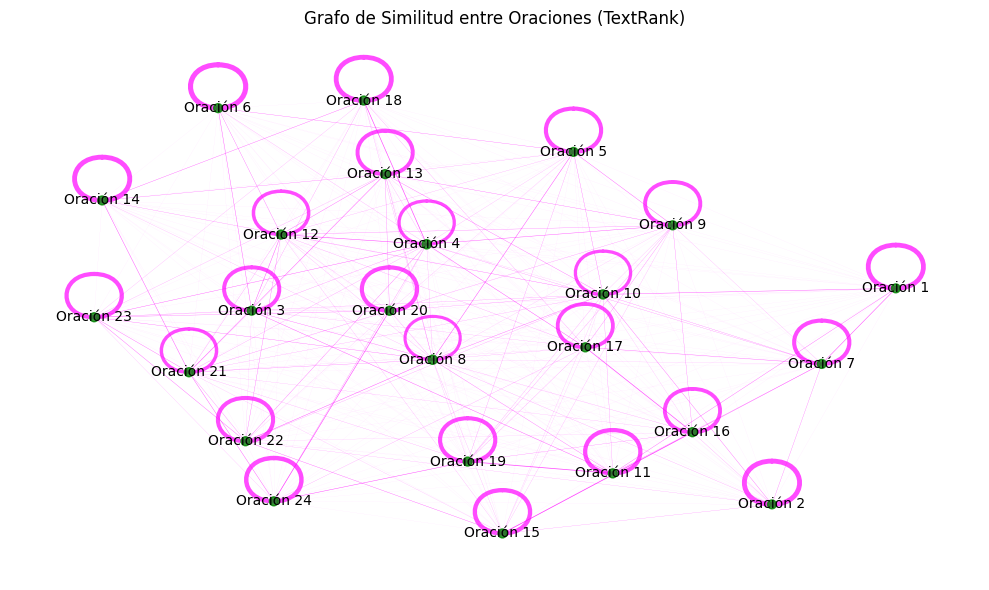

In [87]:
# Visualizamos el grafo
plt.figure(figsize=(10,6))
pos = nx.spring_layout(G, seed=42)

# Dibujamos los nodos con tamaño proporcional al score_G
nx.draw_networkx_nodes(G, pos,
                       node_size=[1000 * scores_G[i] for i in G.nodes()],
                       node_color='green',
                       alpha=0.8)

# Dibujar aristas con pesos
edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos,
                       width=[5 * d['weight'] for (_, _, d) in edges],
                       alpha=0.7,
                       edge_color='fuchsia')

# Etiquetas: mostrar la primera parte de cada oración
labels = {i: f'Oración {i+1}' for i in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10)

plt.title("Grafo de Similitud entre Oraciones (TextRank)")
plt.axis('off')
plt.tight_layout()
plt.show()

#### Explicación

Se crea un grafo no dirigido usando <span style="color:#e60073; font-weight:bold;">G = nx.from_numpy_array(S)</span>, donde cada nodo representa una oración y cada arista la similitud entre ellas. Posteriormente, se utiliza el <span style="color:#e60073; font-weight:bold;">scores = nx.pagerank(G)</span> para rankear la importancia de cada oración, según como se conecta con otras.

Se crea la figura del pyplot de acuerdo al tamaño del grafo y con el <span style="color:#e60073; font-weight:bold;">draw_networkx_nodes</span> se dimensionan los nodos al tamaño del ranking. Luego, el <span style="color:#e60073; font-weight:bold;">draw_networkx_edges</span>, crea las aristas que interconectan cada nodo. 

Finalmente, se crean las etiquetas que aparecerán en cada nodo, para nuestro caso la palabra <span style="color:#e60073; font-weight:bold;">'Oración'</span> y el número del peso de la Matriz de similitud suavizada, para mostrarla a través del <span style="color:#e60073; font-weight:bold;">plt.show()</span>.


## TextRank

### Matriz Estacionaria

Ya tenemos la matriz de transición, que nos indica la probabilidad de pasar de una oración a otra, ahora, necesitamos saber cuál es la probabilidad del estado actual en el tiempo, es decir de la oración que se está analizando sin tener en en cuenta hacia qué otra oración puede ir.

In [92]:
eigen_values, eigen_vectors = np.linalg.eig(S.T)

In [93]:
eigen_values

array([1.        , 0.86664673, 0.84524074, 0.82338475, 0.81472008,
       0.77307318, 0.76045412, 0.74948088, 0.73398798, 0.72032562,
       0.41731513, 0.42223906, 0.45962069, 0.46559459, 0.47809886,
       0.50087105, 0.51123721, 0.65981025, 0.56322085, 0.57564347,
       0.58091814, 0.63872781, 0.61032953, 0.62012229])

In [94]:
# Buscamos la posición donde el eigen_values fue 1
pos_eigen = np.where(np.isclose(eigen_values, 1.0))[0]
print(pos_eigen[0])

0


In [95]:
# Localizamos el eigen_vector de la posición donde halló el 1.0
eigen_vectors[:,pos_eigen[0]]

array([-0.17088315, -0.16683293, -0.20567838, -0.2498079 , -0.19706824,
       -0.15889722, -0.19988734, -0.26248927, -0.20897602, -0.24820384,
       -0.19229987, -0.2317503 , -0.2060358 , -0.16720484, -0.18848506,
       -0.21172529, -0.21567576, -0.16973832, -0.19770387, -0.19485202,
       -0.23640176, -0.20003379, -0.19189516, -0.18299742])

#### Explicación

📌 1. ¿Qué es np.linalg.eig()?
Es una función de NumPy (np) que calcula:

- Los valores propios (eigenvalues): escalares 𝜆
- Los vectores propios (eigenvectors): vectores 𝑣

...de una matriz cuadrada 𝐴, tales que:

                                        𝐴𝑣=𝜆𝑣

📌 2. ¿Qué hace S.T?
S.T es simplemente la transpuesta de la matriz S.
Si 𝑆 es una matriz de tamaño 𝑚×𝑛, entonces 𝑆𝑇 es de tamaño 𝑛×𝑚.

Este paso puede ser necesario si, por ejemplo, queremos que la matriz sea cuadrada para aplicar la descomposición (ya que solo matrices cuadradas tienen valores/vectores propios bien definidos).

📐 ¿Qué significan los eigenvalores y eigenvectores?
- Eigenvalor 𝜆: Indica cuánto se estira o encoge un vector propio al aplicarle la transformación 𝐴.
- Eigenvector 𝑣: Un vector que no cambia de dirección bajo la transformación 𝐴, solo cambia su magnitud.


### Puntuación

In [96]:
scores = eigen_vectors[:,pos_eigen[0]]

In [97]:
sort_index = np.argsort(-scores)

In [98]:
# orden de oraciones más importantes
sort_index

array([ 5,  1, 13, 17,  0, 23, 14, 22, 10, 19,  4, 18,  6, 21,  2, 12,  8,
       15, 16, 11, 20,  9,  3,  7], dtype=int64)

## Resumen

In [111]:
print('Resumen\n')
cantidad_oraciones = 6
for i in sort_index[:cantidad_oraciones]:
    print("\n".join(textwrap.wrap(f"{scores[i]:.2f}: {lineas[i]}", width=50)))

Resumen

-0.16:  Un método muy seguro y probado aunque poco
eficiente desde el punto de vista sostenible, ya
que exige usar equipos computacionales cada vez
más potentes que son grandes consumidores de
energía
-0.17:  Esta analogía define la tarea titánica que
ha supuesto para Ethereum su última actualización
-0.17:  En caso de conductas maliciosas, se podría
penalizar al atacante con parte o la totalidad de
los ethers que bloqueó en un inicio
-0.17:  Como el hilo de Ariadna, este
‘criptoglosario’ muestra cómo se relacionan unos
con otros en la economía que viene… o que ya está
aquí.  Como contrapartida, preocupa la pérdida de
descentralización que podría acarrear PoS
-0.17: Como cambiarle a un coche su motor diésel
por uno eléctrico mientras está en marcha
-0.18:  Un usuario puede depositar sus ‘tokens’
para convertirse en validador, participar de
manera indirecta a través de un ‘exchange’, como
se ha mencionado anteriormente, o prestarlos en
protocolos financieros descentralizados en

## Conclusiones

<div style="text-align: center;">
    <p>La tecnología del método TextRank, evidencia un avance significativo en la realización de resúmenes. Podemos observar la coherencia del texto y como se comprende fácilmente la idea principal de la noticia que se tomó como ejemplo.
     </p>
    <hr/>
    <p style="text-align: right;">Mg. Luis Felipe Bustamante Narváez</p>
</div>